# Forces and Torques Between Cylinders



In [ ]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab. Installing package from pypi')
    !pip install pymagnet -q
else:
    print('Not running on CoLab.')

In [1]:
import numpy as np
import pymagnet as pm
%matplotlib inline
# %matplotlib notebook

%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from numba import njit, guvectorize
PI = np.pi
MU0 = 4e-7*PI

In [2]:
def plot_force_result(offsets,f_total, spacing=None, compare=None, plot_type='force'):
    fig,ax = plt.subplots(figsize=(8,8))
    
    if plot_type.lower() == 'torque':
        labels = [ r"$\tau_x$", r"$\tau_y$", r"$\tau_z$"]
    else:
        labels = [ r"$F_x$", r"$F_y$", r"$F_z$"]
    
    plt.plot(offsets,f_total[:,0], label=labels[0])
    plt.plot(offsets,f_total[:,1], label=labels[1])
    plt.plot(offsets,f_total[:,2], label=labels[2])
    
    if spacing is not None and compare is not None:
        plt.scatter(spacing,compare[0])
        plt.scatter(spacing,compare[1])
        plt.scatter(spacing,compare[2])

    plt.legend(loc='best')
    if plot_type.lower() == 'torque':
        plt.ylabel(r'$\tau$ (mN.m)')
    else:
        plt.ylabel(r'$F$ (N)')
    plt.xlabel(r"$d$ (mm)")
    plt.grid(True)
    plt.show()

In [3]:
# def gen_cylinders(offset_z=0.0):

#     pm.reset_magnets()

#     center = (0, 0, 0 -20)    
#     radius = 12.7   
#     length_1 = 9.5
#     alpha = 0
#     beta = 0
#     gamma = 0
#     mask_magnet = False # mask values inside a magnet
#     show_magnets = True

#     m1 = pm.magnets.Cylinder(radius = radius, length = length_1, Jr = 0.89,
#                                 center=center,
#                                 theta = 0, phi = 0,
#                                 alpha = alpha,
#                                 beta = beta,
#                                 gamma = gamma,
#                                 mask_magnet=mask_magnet)
#     radius = 6.35
#     length_2 = 4.85

#     gap = 0
#     center = (-3, 3, length_1/2 + length_2/2 + offset_z -20)    

#     m2 = pm.magnets.Cylinder(radius = radius, length = length_2, Jr = -0.92,
#                                 center=center,
#                                 theta = 0, phi = 0,
#                                 alpha = alpha,
#                                 beta = beta,
#                                 gamma = gamma,
#                                 mask_magnet=mask_magnet)
#     return m1, m2

In [4]:
# compare = np.zeros((3,30))
# spacing = np.array([5.943,6.764,7.632,8.548,9.479,10.41,11.358,12.32,13.268,14.23,16.188,18.145,20.087,25.075,30.047,39.98,49.984,59.929])
# compare[2] = -1*np.array([6.912,5.725,4.766,4.01,3.4,2.903,2.493,2.162,1.879,1.647,1.275,0.996,0.79,0.454,0.275,0.114,0.055,0.03])
# spacing = np.array([0.042,3.008,3.475,4.725,5.021,6.377,7.86,9.343,10.89,12.394,13.814,15.36,16.864,16.822,18.114,18.475,19.894,21.271,22.839,24.343,25.805,27.267,28.835,30.212,31.78,33.305,34.767,36.292,37.775,39.195])
# compare[2] = np.array([9.036,8.31,8.352,7.577,7.577,6.55,5.454,4.49,3.652,3.01,2.472,2.011,1.697,1.592,1.369,1.355,1.131,0.971,0.775,0.663,0.566,0.482,0.426,0.363,0.335,0.279,0.272,0.223,0.203,0.161])


Comparison data from 

R. Ravaud, G. Lemarquand, S. Babic, V. Lemarquand, and C. Akyel, Cylindrical Magnets and Coils: Fields, Forces, and Inductances, IEEE Transactions on Magnetics 46, 3585 (2010).


In [3]:
def gen_cylinders(offset_z=0.0, alpha = 0, beta = 0, gamma = 0):

    pm.reset_magnets()

    Jr = 8e3*MU0
    mask_magnet = False # mask values inside a magnet
    show_magnets = True
    
    radius = 87.5   
    length_1 = 25

    center = (0, 0, -length_1/2 - offset_z/2)    

    m1 = pm.magnets.Cylinder(radius = radius, length = length_1, Jr = Jr,
                                center=center,
                                theta = 0, phi = 0,
                                alpha = alpha,
                                beta = beta,
                                gamma = gamma,
                                mask_magnet=mask_magnet)
    radius = 87.5
    length_2 = 25

    gap = 0
    center = (0, 0, length_2/2 + offset_z/2)    
    alpha = 0
    beta = 0
    gamma = 0
    m2 = pm.magnets.Cylinder(radius = radius, length = length_2, Jr = Jr,
                                center=center,
                                theta = 0, phi = 0,
                                alpha = alpha,
                                beta = beta,
                                gamma = gamma,
                                mask_magnet=mask_magnet)
    return m1, m2

Comparison data from 

R. Ravaud, G. Lemarquand, S. Babic, V. Lemarquand, and C. Akyel, Cylindrical Magnets and Coils: Fields, Forces, and Inductances, IEEE Transactions on Magnetics 46, 3585 (2010).


In [4]:
m1,m2 = gen_cylinders(offset_z=5)


num_samples=20
unit = 'mm'


force, torque = m1.get_force_torque(num_samples = num_samples, unit=unit)

print(force)
print(torque*1e3)

[-4.35391193e-17 -3.06890320e-17  1.59481584e-01]
[ 1.00139974e-15 -2.83971812e-15  1.89066358e-17]


NOTE FORCES ARE ACTUALLY mN NOT N!


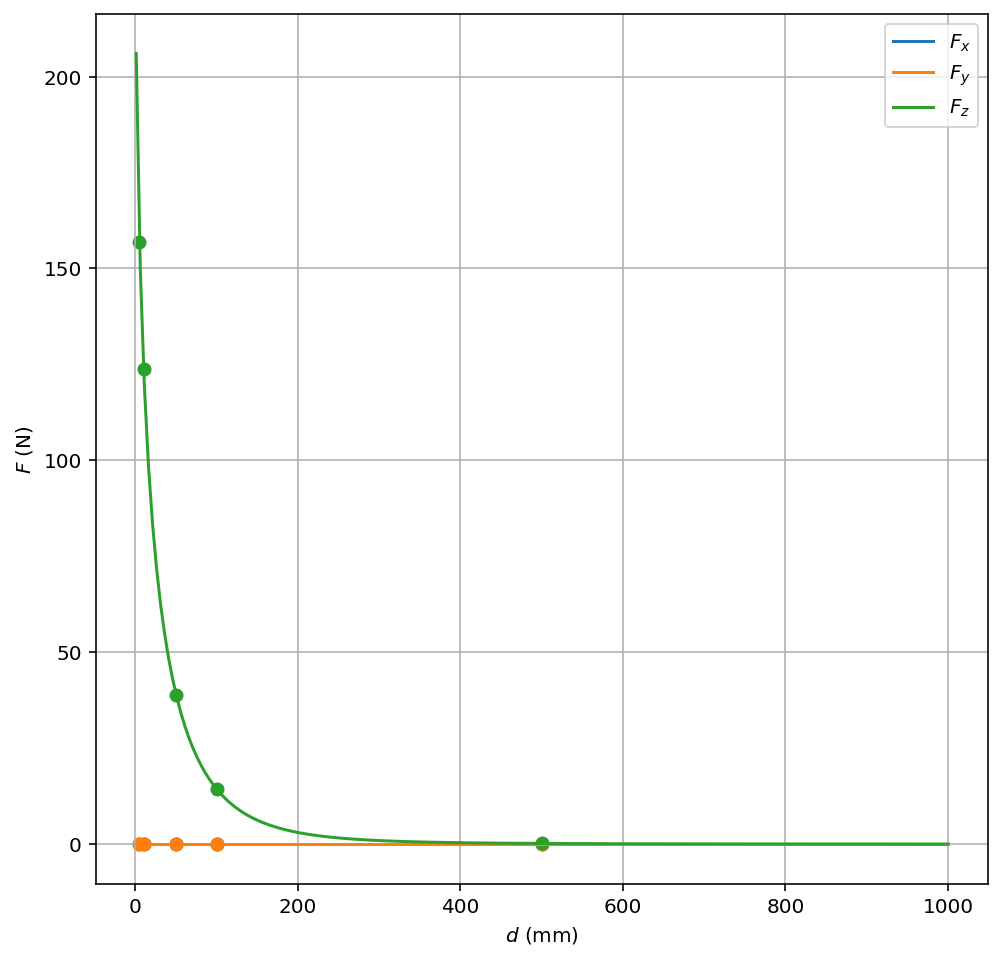

In [28]:
spacing = np.array([5, 10, 50, 100, 500])
compare = np.zeros((3, 5))
compare[2] = np.array([157, 123.7977, 38.8386, 14.281, 0.160674])




num_segments = 40
force_points = 201
offsets = np.linspace(1,1000,force_points)

f_total = np.zeros((force_points,3))
t_total = np.zeros((force_points,3))
unit = 'mm'

for i in range(force_points):
    m1, m2 = gen_cylinders(offset_z = offsets[i])
    f_total[i], t_total[i] = m1.get_force_torque(num_samples = num_samples, unit=unit)

    
print("NOTE FORCES ARE ACTUALLY mN NOT N!")
plot_force_result(offsets,f_total*1e3, spacing, compare, plot_type='force')
# plot_force_result(offsets,t_total*1e3, None, None, plot_type='torque')

3D Rendering:
![Ravaud 2010](img/ravaud2010.png)

In [ ]:
mask_magnet = False
m1, m2 = gen_cylinders(offset_z = 40)
fig_slice, slice_cache, data_objects = pm.plots.slice_quickplot(cmax=0.005,
                                              num_levels=11,
                                              opacity=1.0,
                                              num_arrows=10,
                                              num_points=200,
                                              cone_opacity=0.9,
                                              magnet_opacity=1.0,
                                              mask_magnet = mask_magnet,
                                              show_magnets=True,
                                              max1 = 120,
                                              max2 = 120,
                                              slice_value= 0.0,
                                              unit = 'mm'
                               )

In [29]:
def gen_cylinders_small(offset_z=0.0, alpha = 0, beta = 0, gamma = 0, repulsive=True):

    pm.reset_magnets()

    Jr = 1.0
    mask_magnet = False # mask values inside a magnet
    show_magnets = True
    
    radius = 20   
    length_1 = 5

    center = (0, 0, -length_1/2 - offset_z/2)    

    m1 = pm.magnets.Cylinder(radius = radius, length = length_1, Jr = Jr,
                                center=center,
                                theta = 0, phi = 0,
                                alpha = alpha,
                                beta = beta,
                                gamma = gamma,
                                mask_magnet=mask_magnet)
    radius = 20   
    length_2 = 5

    gap = 0
    center = (5, -5, length_2/2 + offset_z/2)    
    alpha = 0
    beta = 0
    gamma = 0
    if repulsive:
        Jr *= -1
    m2 = pm.magnets.Cylinder(radius = radius, length = length_2, Jr = Jr,
                                center=center,
                                theta = 0, phi = 0,
                                alpha = alpha,
                                beta = beta,
                                gamma = gamma,
                                mask_magnet=mask_magnet)
    return m1, m2

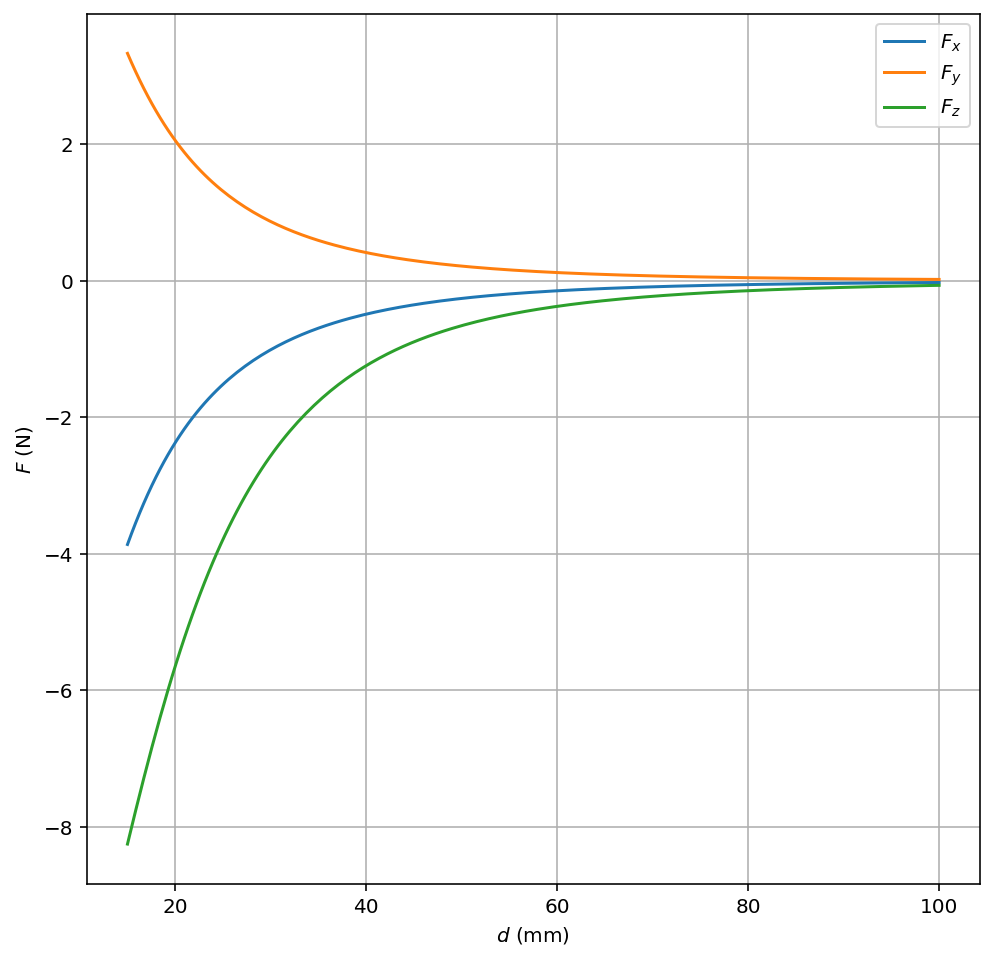

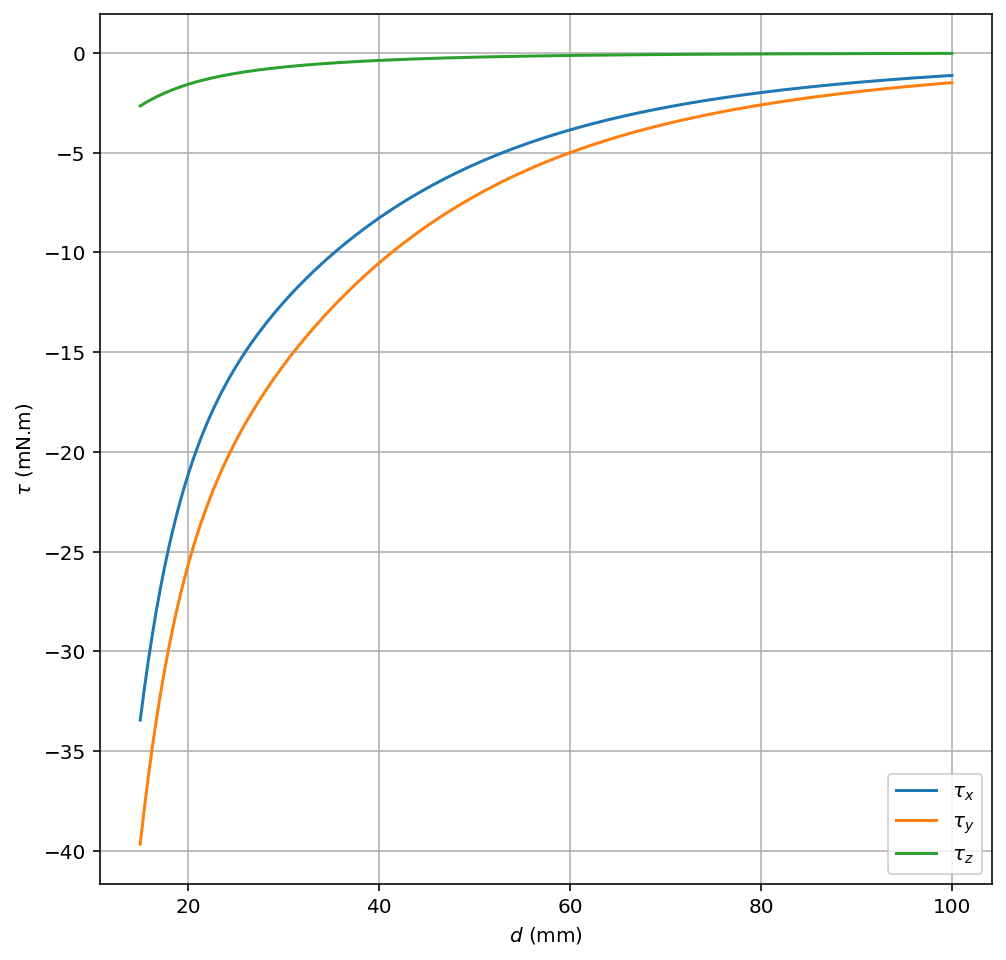

In [30]:

num_samples = 40
force_points = 201
offsets = np.linspace(15,100,force_points)

f_total = np.zeros((force_points,3))
t_total = np.zeros((force_points,3))
unit = 'mm'

for i in range(force_points):
    m1, m2 = gen_cylinders_small(offset_z = offsets[i],alpha=0, beta= 30, gamma=20)
    f_total[i], t_total[i] = m1.get_force_torque(num_samples=num_samples, unit=unit)


plot_force_result(offsets,f_total, None, None, plot_type='force')
plot_force_result(offsets,t_total*1e3, None, None, plot_type='torque')

3D Rendering:
![Discs slice](img/rotated_discs_slice.png)

In [ ]:
m1, m2 = gen_cylinders_small(offset_z = 15,alpha=0, beta= 30, gamma=20)
fig_slice, slice_cache, data_objects = pm.plots.slice_quickplot(cmax=0.3,
                                              num_levels=7,
                                              opacity=1.0,
                                              num_arrows=10,
                                              num_points=200,
                                              cone_opacity=0.9,
                                              magnet_opacity=1.0,
                                              mask_magnet = 'nan',
                                              show_magnets=True,
                                              colorscale='viridis',
                                              max1 = 30,
                                              max2 = 30,
                                              slice_value= 0.0,
                                              unit = 'mm'
                               )

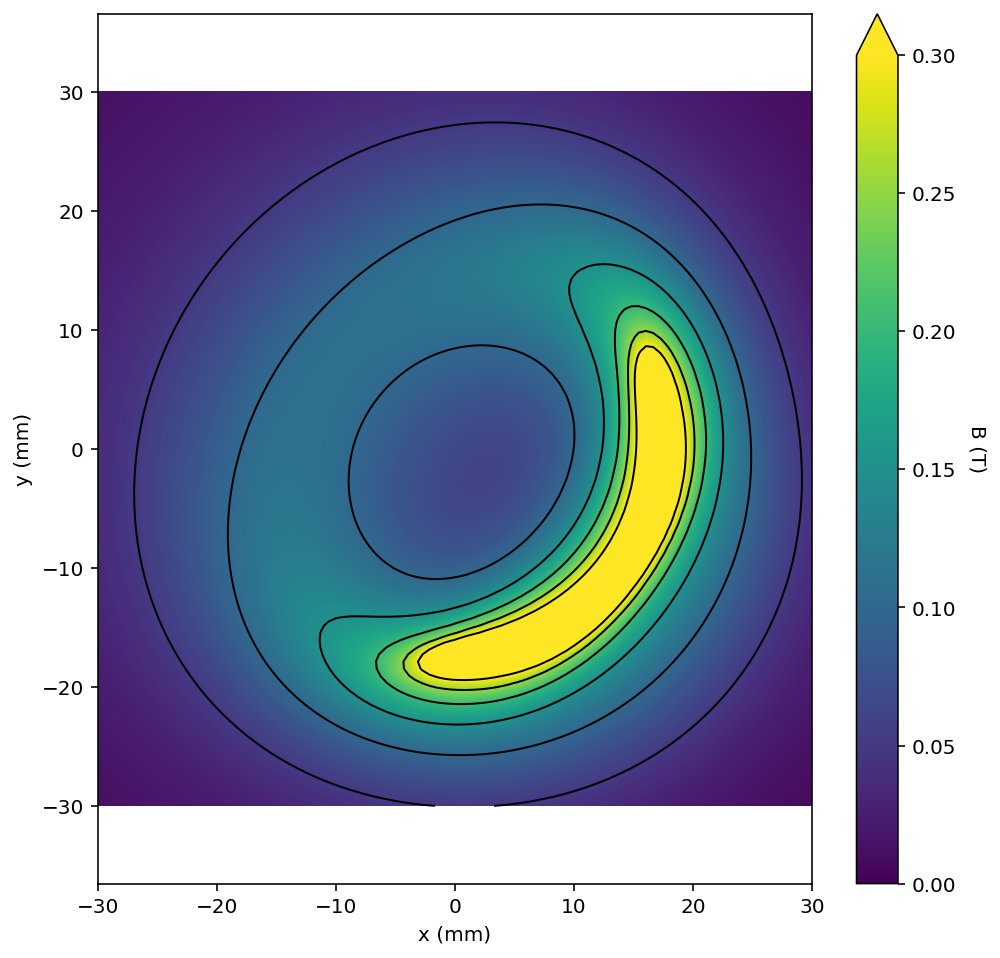

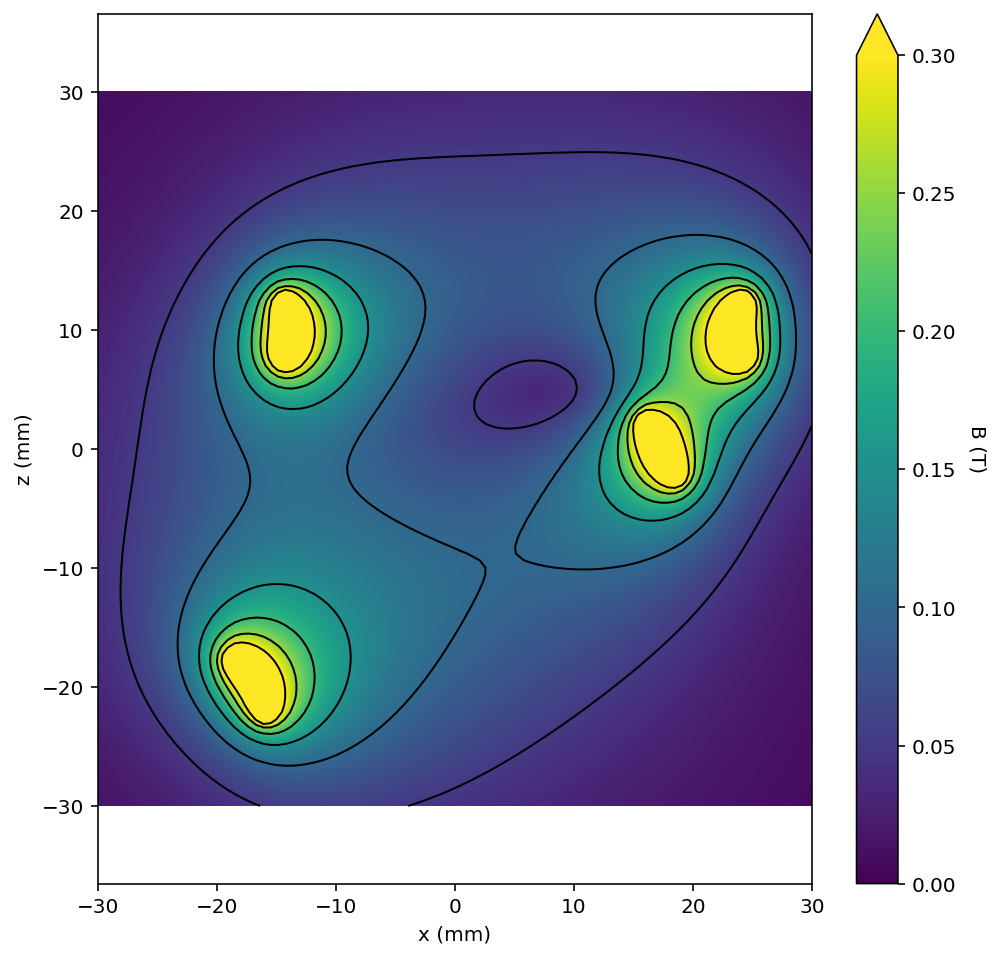

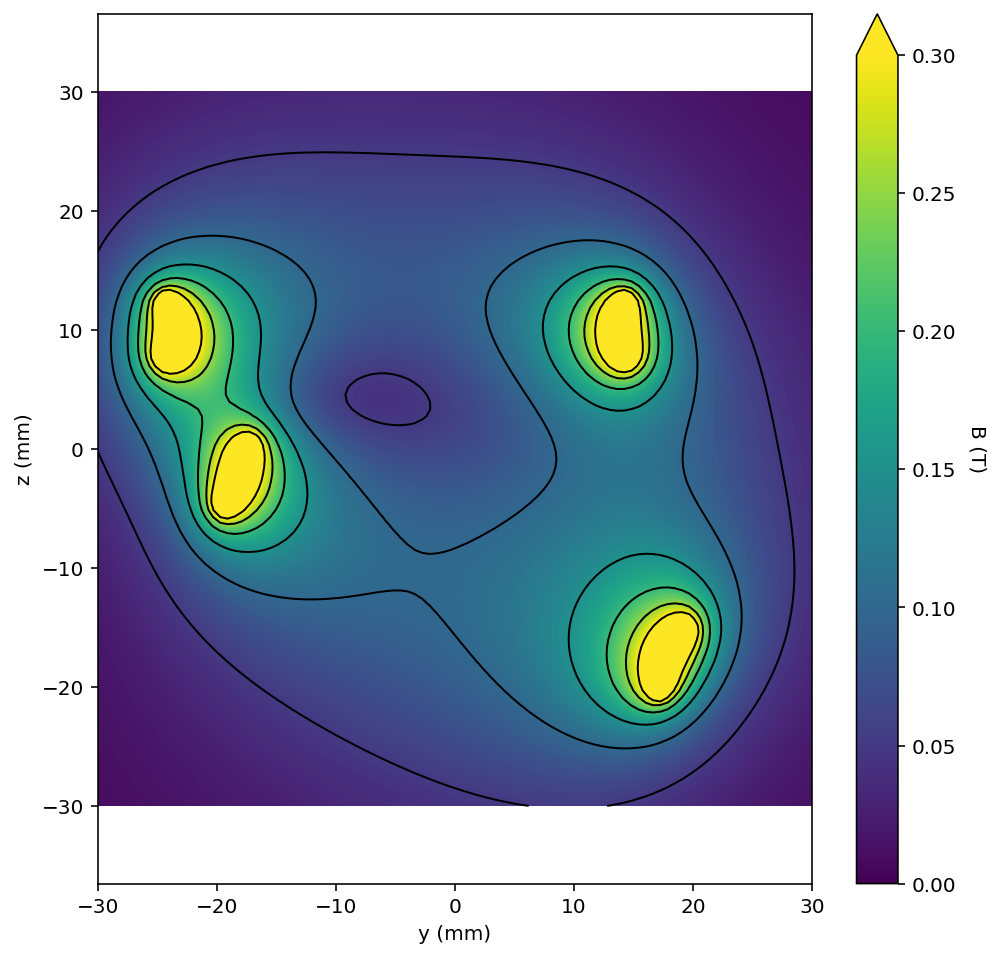

In [32]:
 for plane in slice_cache.keys():
    pm.plots.plot_3D_contour(slice_cache[plane]['points'], slice_cache[plane]['field'], plane,
                             cmin = 0,
                             cmax=0.3,
                             num_levels=7,
                             cmap='viridis',
                             
#                              num_arrows = 21,
#                              vector_color = 'k'
#                              plot_type="streamplot",
    #                          stream_color= 'vertical'
                            )


3D Rendering:
![Discs Volume](img/rotated_discs_volume.png)

In [ ]:
fig_vol, vol_cache, data_objects = pm.plots.volume_quickplot(cmin=0.0,
                                    cmax=0.3,
                                    opacity=0.3,
                                    magnet_opacity=1.0,
                                    no_caps=True,
                                    num_levels=7,
                                    num_points=50,
                                    show_magnets = True,
                                    xmax = 40,
                                    ymax = 40,
                                    zmax = 40,
                                    unit = 'mm',
                                    opacityscale = 'normal',
                                    isomin=0.05,
                                    isomax=0.3,
                                   )
